In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count, prepare_df

Hill Function Parameters by Sector:
   mu_ub  mu_lb       K        m
G  0.137  0.036  12.391    4.144
M  0.109  0.042  12.553    4.414
F  0.080  0.000  26.182   80.000
J  0.131  0.038  11.943    4.057
K  0.070  0.011  17.601   11.720
C  0.103  0.041   9.260    8.139
H  0.190  0.028   6.938  100.000
S  0.141  0.000  12.954    5.190
N  0.124  0.000  16.433    3.676
I  0.126  0.034  17.443    5.606
P  0.121  0.069   9.445  100.000
L  0.074  0.000  25.775   79.999
Q  0.078  0.047   7.792  100.000
R  0.132  0.085   8.857  100.000


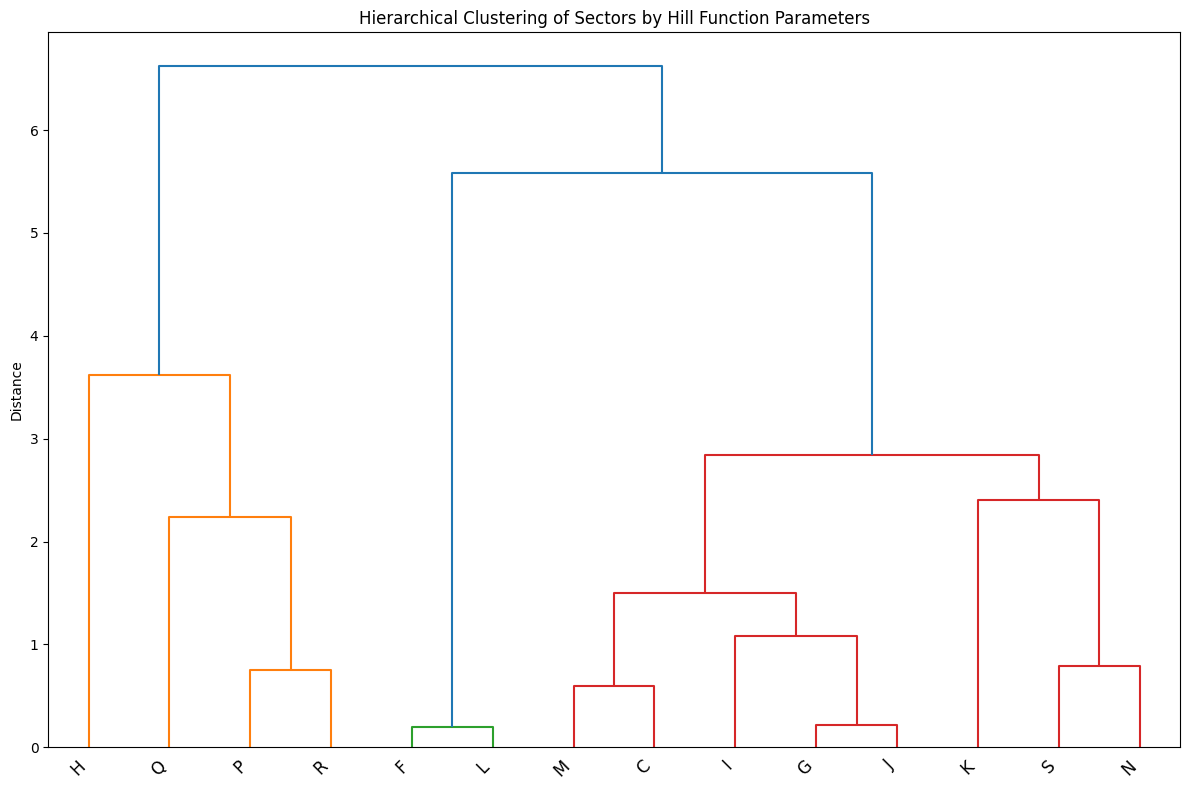


2 Clusters:
  G: Cluster 2
  M: Cluster 2
  F: Cluster 2
  J: Cluster 2
  K: Cluster 2
  C: Cluster 2
  H: Cluster 1
  S: Cluster 2
  N: Cluster 2
  I: Cluster 2
  P: Cluster 1
  L: Cluster 2
  Q: Cluster 1
  R: Cluster 1

3 Clusters:
  G: Cluster 3
  M: Cluster 3
  F: Cluster 2
  J: Cluster 3
  K: Cluster 3
  C: Cluster 3
  H: Cluster 1
  S: Cluster 3
  N: Cluster 3
  I: Cluster 3
  P: Cluster 1
  L: Cluster 2
  Q: Cluster 1
  R: Cluster 1

4 Clusters:
  G: Cluster 4
  M: Cluster 4
  F: Cluster 3
  J: Cluster 4
  K: Cluster 4
  C: Cluster 4
  H: Cluster 2
  S: Cluster 4
  N: Cluster 4
  I: Cluster 4
  P: Cluster 1
  L: Cluster 3
  Q: Cluster 1
  R: Cluster 1

5 Clusters:
  G: Cluster 4
  M: Cluster 4
  F: Cluster 3
  J: Cluster 4
  K: Cluster 5
  C: Cluster 4
  H: Cluster 2
  S: Cluster 5
  N: Cluster 5
  I: Cluster 4
  P: Cluster 1
  L: Cluster 3
  Q: Cluster 1
  R: Cluster 1

6 Clusters:
  G: Cluster 4
  M: Cluster 4
  F: Cluster 3
  J: Cluster 4
  K: Cluster 6
  C: Cluster 4
  H: 

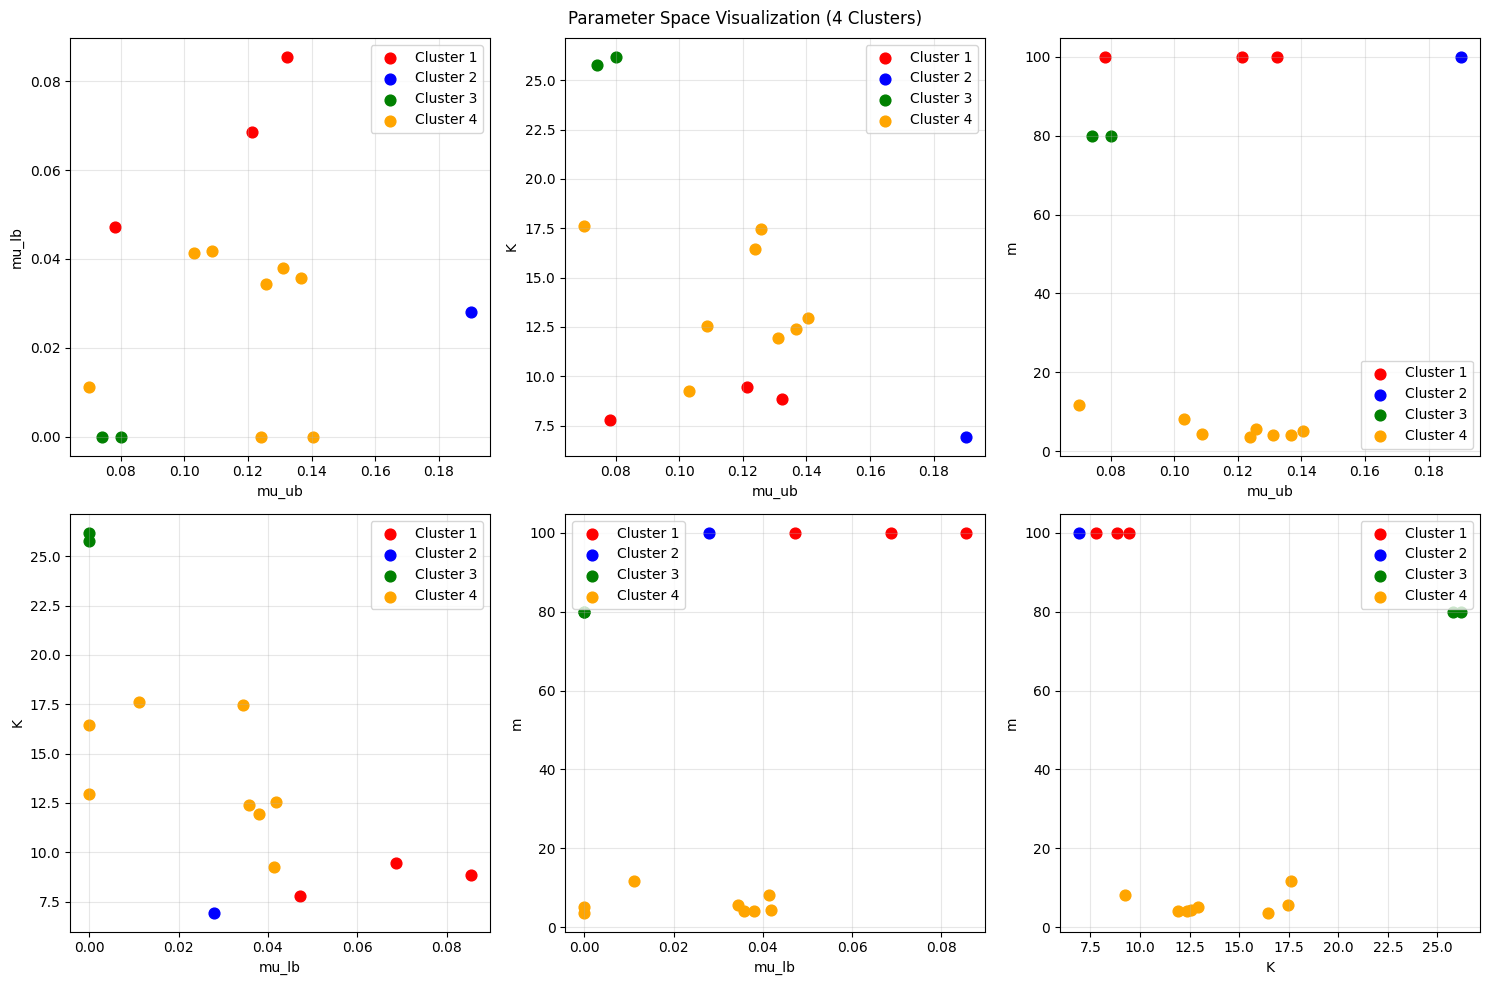


Cluster Representatives (k=4):

Cluster 1 (3 sectors):
  Sectors: ['P', 'Q', 'R']
  Mean parameters:
    mu_ub: 0.111
    mu_lb: 0.067
    K: 8.698
    m: 100.000

Cluster 2 (1 sectors):
  Sectors: ['H']
  Mean parameters:
    mu_ub: 0.190
    mu_lb: 0.028
    K: 6.938
    m: 100.000

Cluster 3 (2 sectors):
  Sectors: ['F', 'L']
  Mean parameters:
    mu_ub: 0.077
    mu_lb: 0.000
    K: 25.979
    m: 79.999

Cluster 4 (8 sectors):
  Sectors: ['G', 'M', 'J', 'K', 'C', 'S', 'N', 'I']
  Mean parameters:
    mu_ub: 0.117
    mu_lb: 0.025
    K: 13.822
    m: 5.868


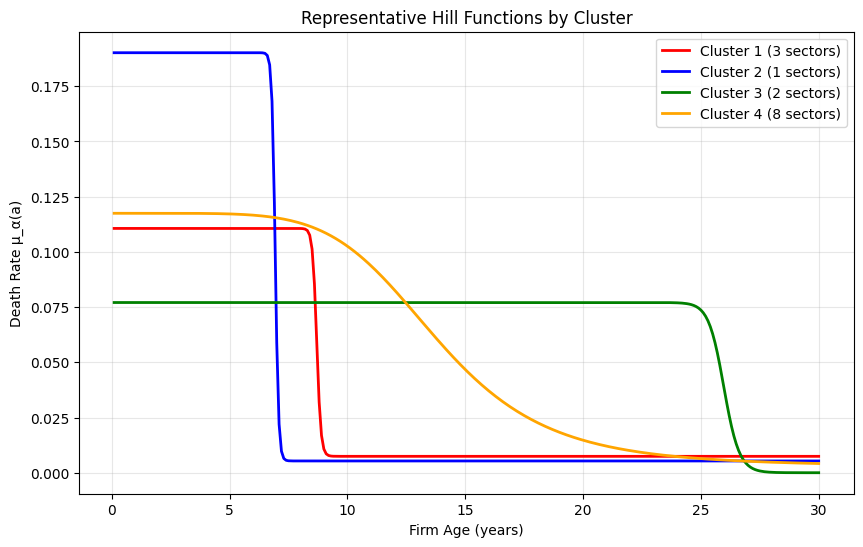


Cluster Quality Assessment:
k=2: Average Silhouette Score = 0.374
k=3: Average Silhouette Score = 0.476
k=4: Average Silhouette Score = 0.483
k=5: Average Silhouette Score = 0.433
k=6: Average Silhouette Score = 0.465
k=7: Average Silhouette Score = 0.457
k=8: Average Silhouette Score = 0.423
k=9: Average Silhouette Score = 0.440
k=10: Average Silhouette Score = 0.378
k=11: Average Silhouette Score = 0.291
k=12: Average Silhouette Score = 0.235
k=13: Average Silhouette Score = 0.130

Cluster Assignments:
   2_clusters  3_clusters  4_clusters  5_clusters  6_clusters  7_clusters  \
G           2           3           4           4           4           5   
M           2           3           4           4           4           5   
F           2           2           3           3           3           4   
J           2           3           4           4           4           5   
K           2           3           4           5           6           7   
C           2           3  

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import seaborn as sns

# # Example: Simulate Hill function parameters for 14 sectors
# np.random.seed(42)
# sector_list = ['Wholesale/Retail', 'Prof/Science/Tech', 'Finance/Insurance', 
#                 'Info & Comms', 'Construction', 'Manufacturing', 'Transport',
#                 'Real Estate', 'Admin Services', 'Accommodation', 'Education',
#                 'Health/Social', 'Arts/Entertainment', 'Other Services']

# # Simulate Hill function parameters (μ_α,ub, μ̃_α, K_α, m_α)
# # In practice, these would come from your MLE fitting
# n_sectors = 14
# parameters = np.random.rand(n_sectors, 4)
# parameters[:, 0] *= 0.2  # μ_α,ub: death rate upper bound
# parameters[:, 1] = 0.1 + parameters[:, 1] * 0.4  # μ̃_α: relative lower bound
# parameters[:, 2] = 2 + parameters[:, 2] * 8  # K_α: age midpoint
# parameters[:, 3] = 1 + parameters[:, 3] * 3  # m_α: hill coefficient

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [[0.13660027, 0.03574423, 12.39113424, 4.14356328],
[0.10877533,	0.0418096,	12.55269306,	4.41391222],
[0.079990154,	1.00E-10,	26.18237719,	79.99986416],
[0.13090805,	0.03791174,	11.9429807,	4.05657508],
[0.070120134,	0.011071032,	17.60063205,	11.71975389],
[0.10301031,	0.04128293,	9.26045477,	8.13925264],
[0.190143914,	0.028016019,	6.93767599,	100],
[0.14058029,	1.00E-10,	12.9535533,	5.1898739],
[0.12396223,	1.00E-10,	16.4327672,	3.67640026],
[0.12568692,	0.03447114,	17.44283135,	5.60609428],
[0.121213526,	0.068684245,	9.44518567,	100],
[0.074121126,	1.00E-10,	25.77531849,	79.99860496],
[0.078301599,	0.047197935,	7.79197632,	100],
[0.132289514,	0.085485775,	8.85732298,	100]
]

# Create DataFrame
df = pd.DataFrame(parameters, 
                 columns=['mu_ub', 'mu_lb', 'K', 'm'],
                 index=sector_list)

print("Hill Function Parameters by Sector:")
print(df.round(3))

# Step 1: Standardize parameters (important due to different scales)
scaler = StandardScaler()
parameters_scaled = scaler.fit_transform(parameters)

# Step 2: Compute distance matrix
distance_matrix = pdist(parameters_scaled, metric='euclidean')

# Step 3: Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')

# Step 4: Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=sector_list, orientation='top')
plt.title('Hierarchical Clustering of Sectors by Hill Function Parameters')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 5: Cut dendrogram to get clusters
n_clusters_options = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
cluster_results = {}

for k in n_clusters_options:
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    cluster_results[k] = clusters
    
    print(f"\n{k} Clusters:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {clusters[i]}")

# Step 6: Visualize clusters in parameter space
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

parameter_pairs = [
    ('mu_ub', 'mu_lb'),
    ('mu_ub', 'K'),
    ('mu_ub', 'm'),
    ('mu_lb', 'K'),
    ('mu_lb', 'm'),
    ('K', 'm')
]

for idx, (param1, param2) in enumerate(parameter_pairs):
    ax = axes[idx]
    
    # Plot for k=3 clusters as example
    clusters = cluster_results[4]
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        ax.scatter(df.loc[mask, param1], df.loc[mask, param2], 
                  c=colors[cluster_id-1], label=f'Cluster {cluster_id}', s=60)
    
    ax.set_xlabel(param1)
    ax.set_ylabel(param2)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Parameter Space Visualization (4 Clusters)')
plt.tight_layout()
plt.show()

# Step 7: Compute cluster-representative parameters
def compute_cluster_representatives(df, clusters, k):
    """Compute mean parameters for each cluster"""
    cluster_reps = {}
    
    for cluster_id in range(1, k+1):
        mask = clusters == cluster_id
        cluster_sectors = df.index[mask].tolist()
        cluster_params = df.loc[mask].mean()
        
        cluster_reps[cluster_id] = {
            'sectors': cluster_sectors,
            'parameters': cluster_params,
            'n_sectors': sum(mask)
        }
    
    return cluster_reps

# Example for k=3
cluster_reps = compute_cluster_representatives(df, cluster_results[4], 4)

print("\nCluster Representatives (k=4):")
for cluster_id, info in cluster_reps.items():
    print(f"\nCluster {cluster_id} ({info['n_sectors']} sectors):")
    print(f"  Sectors: {info['sectors']}")
    print(f"  Mean parameters:")
    for param, value in info['parameters'].items():
        print(f"    {param}: {value:.3f}")

# Step 8: Hill function for visualization
def hill_function_mu_alpha(a, mu_ub, mu_lb, K, m):
    """Hill function for age-dependent death rate"""
    mu_lb = mu_lb * mu_ub
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m)

# Plot representative Hill functions for each cluster
ages = np.linspace(0.1, 30, 300)
plt.figure(figsize=(10, 6))

colors = ['red', 'blue', 'green', 'orange', 'purple']
for cluster_id, info in cluster_reps.items():
    params = info['parameters']
    mu_alpha = hill_function_mu_alpha(ages, 
                                     params['mu_ub'],
                                     params['mu_lb'], 
                                     params['K'],
                                     params['m'])
    
    plt.plot(ages, mu_alpha, color=colors[cluster_id-1], linewidth=2,
             label=f'Cluster {cluster_id} ({info["n_sectors"]} sectors)')

plt.xlabel('Firm Age (years)')
plt.ylabel('Death Rate μ_α(a)')
plt.title('Representative Hill Functions by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Step 9: Assess cluster quality using silhouette analysis
from sklearn.metrics import silhouette_score, silhouette_samples

print("\nCluster Quality Assessment:")
for k in n_clusters_options:
    clusters = cluster_results[k]
    silhouette_avg = silhouette_score(parameters_scaled, clusters)
    print(f"k={k}: Average Silhouette Score = {silhouette_avg:.3f}")

# Step 10: Export results
results_df = pd.DataFrame(cluster_results, index=sector_list)
results_df.columns = [f'{k}_clusters' for k in n_clusters_options]
print("\nCluster Assignments:")
print(results_df)

In [4]:
from survival_analysis import prepare_df

df = prepare_df()

df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


Individual Sector Parameters:
      mu_ub         mu_lb          K           m
G  0.136600  3.574423e-02  12.391134    4.143563
M  0.108775  4.180960e-02  12.552693    4.413912
F  0.079990  1.000000e-10  26.182377   79.999864
J  0.130908  3.791174e-02  11.942981    4.056575
K  0.070120  1.107103e-02  17.600632   11.719754
C  0.103010  4.128293e-02   9.260455    8.139253
H  0.190144  2.801602e-02   6.937676  100.000000
S  0.140580  1.000000e-10  12.953553    5.189874
N  0.123962  1.000000e-10  16.432767    3.676400
I  0.125687  3.447114e-02  17.442831    5.606094
P  0.121214  6.868425e-02   9.445186  100.000000
L  0.074121  1.000000e-10  25.775318   79.998605
Q  0.078302  4.719794e-02   7.791976  100.000000
R  0.132290  8.548577e-02   8.857323  100.000000
Initializing with k-means clustering...
Initial cluster assignments:
  G: Cluster 0
  M: Cluster 0
  F: Cluster 1
  J: Cluster 0
  K: Cluster 0
  C: Cluster 0
  H: Cluster 1
  S: Cluster 0
  N: Cluster 0
  I: Cluster 0
  P: Cluster 1
 

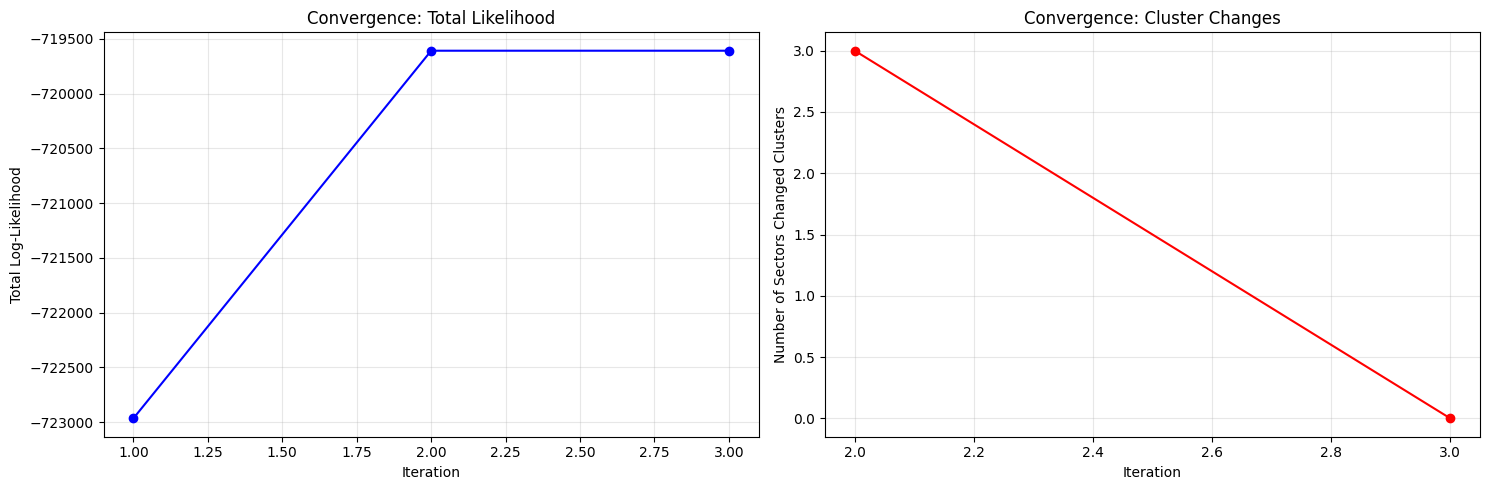

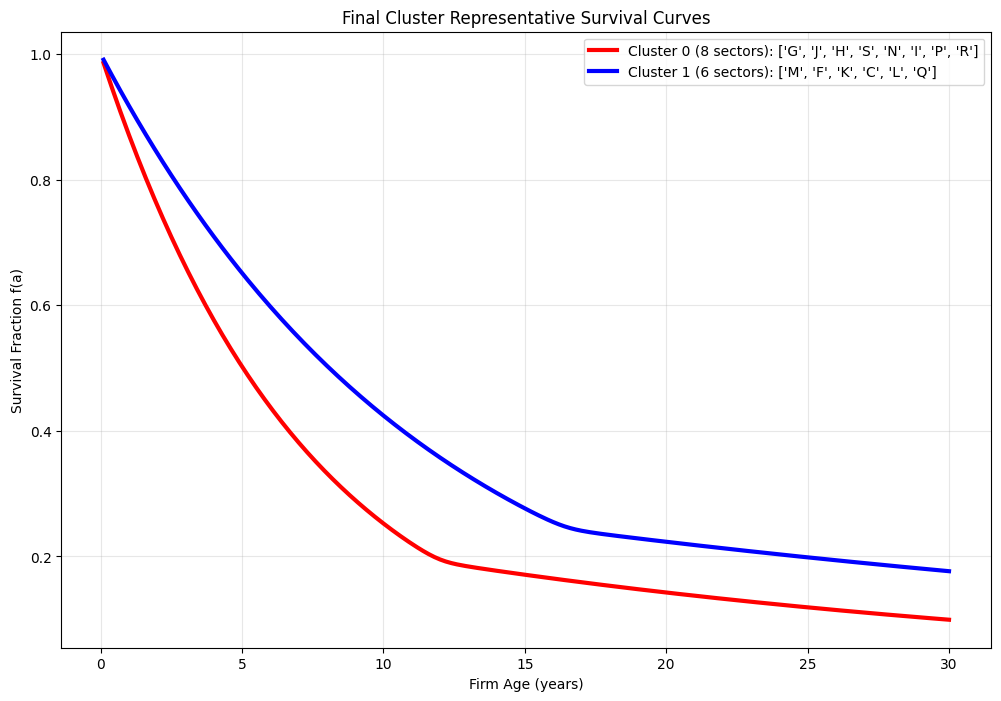

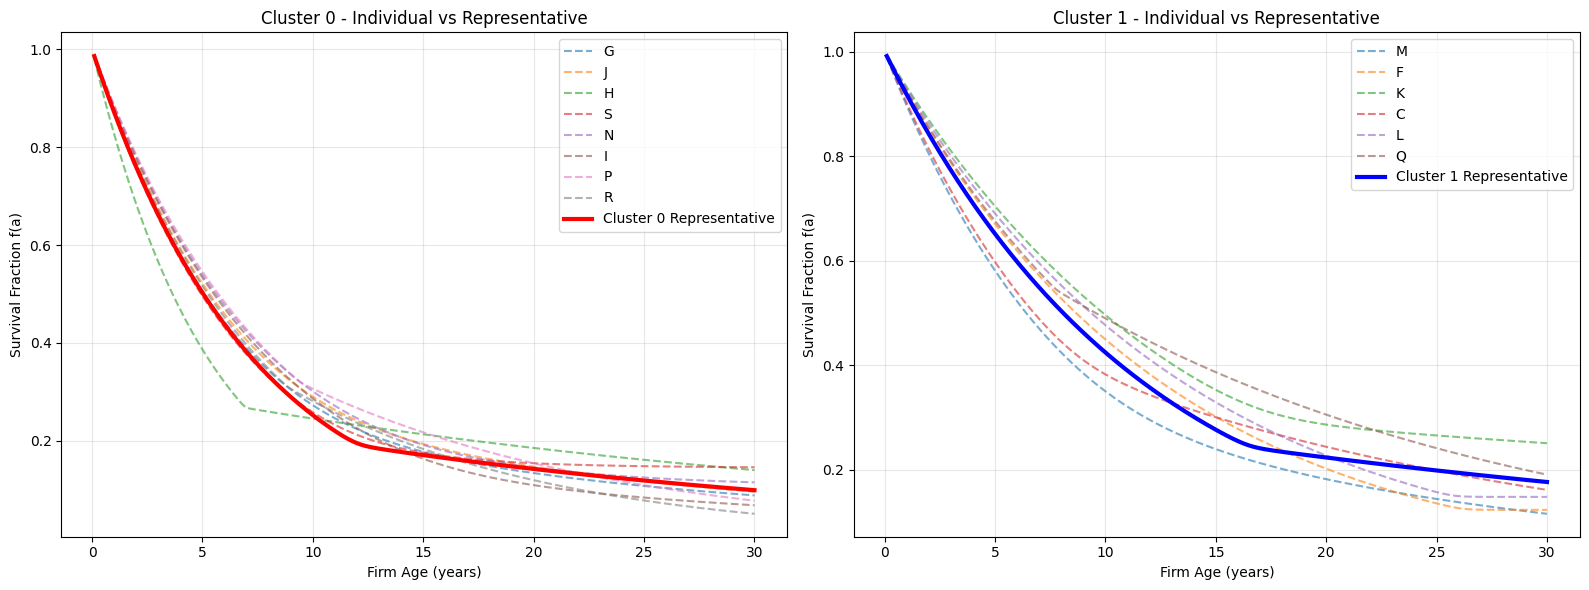

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)


def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])


# # Simulate some f(a) data for each sector (in practice, you'd have real data)
# np.random.seed(42)
# ages_data = np.linspace(0, 30, 60)  # Age points where you have data

# # Generate synthetic f(a) data using the fitted parameters + noise
# survival_data = {}
# for i, sector in enumerate(sector_list):
#     params = parameters[i]
#     true_survival = model_survival_curve_hill(ages_data, *params)
#     # Add some noise to simulate real data
#     noisy_survival = true_survival * (1 + 0.05 * np.random.randn(len(ages_data)))
#     noisy_survival = np.clip(noisy_survival, 0.01, 1.0)  # Keep in valid range
#     survival_data[sector] = noisy_survival

# print(f"\nGenerated survival data for {len(ages_data)} age points per sector")

survival_data = {}
for sector in sector_list:
    survival_data[sector], ages_data = obtain_survival_fractions(df_analysis, 'Sector', sector)


# Log-likelihood function
# def log_likelihood(survival_obs, survival_pred, sigma=0.05):
#     """
#     Compute log-likelihood assuming Gaussian noise
#     """
#     residuals = survival_obs - survival_pred
#     ll = -0.5 * np.sum(residuals**2 / sigma**2) - 0.5 * len(residuals) * np.log(2 * np.pi * sigma**2)
#     return ll

# def compute_sector_likelihood(sector_data, model_params):
#     """
#     Compute likelihood of sector data given model parameters
#     """
#     predicted_survival = model_survival_curve_hill(ages_data, *model_params)
#     return log_likelihood(sector_data, predicted_survival)

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def compute_sector_likelihood(sector, model_params):
    """    
    Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    return log_likelihood(model_params, ages_data, survivors, totals)
    

# Iterative clustering algorithm
def iterative_likelihood_clustering(survival_data, df_params, max_iterations=20, tolerance=1e-6):
    """
    Iterative clustering using direct likelihood comparison
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print("Initializing with k-means clustering...")
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in [0, 1]:
        mask = initial_clusters == cluster_id
        cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters:")
    for cluster_id, params in cluster_params.items():
        print(f"  Cluster {cluster_id}: {params}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            sector_data = survival_data[sector]
            
            # Compute likelihood for each cluster model
            ll_0 = compute_sector_likelihood(sector, cluster_params[0])
            ll_1 = compute_sector_likelihood(sector, cluster_params[1])
            
            # Assign to cluster with higher likelihood
            if ll_0 > ll_1:
                new_clusters[i] = 0
            else:
                new_clusters[i] = 1
            
            sector_likelihoods[sector] = {'ll_0': ll_0, 'll_1': ll_1, 'assigned': new_clusters[i]}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            print(f"  {sector}: LL_0={lls['ll_0']:.2f}, LL_1={lls['ll_1']:.2f} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters
        new_cluster_params = {}
        for cluster_id in [0, 1]:
            mask = new_clusters == cluster_id
            if np.sum(mask) > 0:  # Check if cluster is non-empty
                new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                # Keep old parameters if cluster becomes empty
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters:")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): {params}")
        
        # Check convergence
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        param_change = 0
        for cluster_id in [0, 1]:
            param_change += np.sum((new_cluster_params[cluster_id] - cluster_params[cluster_id])**2)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Parameter change: {param_change:.6f}")
        
        if not clusters_changed and param_change < tolerance:
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            sector_data = survival_data[sector]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Run the clustering
final_clusters, final_params, history = iterative_likelihood_clustering(survival_data, df_params)

print(f"\n{'='*50}")
print("FINAL RESULTS")
print(f"{'='*50}")

print("\nFinal cluster assignments:")
for i, sector in enumerate(sector_list):
    print(f"  {sector}: Cluster {final_clusters[i]}")

print("\nFinal cluster parameters:")
for cluster_id, params in final_params.items():
    n_sectors = np.sum(final_clusters == cluster_id)
    sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
    print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
    print(f"  mu_ub: {params[0]:.6f}")
    print(f"  mu_lb: {params[1]:.6f}")
    print(f"  K: {params[2]:.6f}")
    print(f"  m: {params[3]:.6f}")

# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot total likelihood over iterations
axes[0].plot(history['iteration'], history['total_likelihood'], 'bo-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Total Log-Likelihood')
axes[0].set_title('Convergence: Total Likelihood')
axes[0].grid(True, alpha=0.3)

# Plot cluster assignments over iterations
cluster_changes = []
for i in range(1, len(history['cluster_assignments'])):
    prev_clusters = history['cluster_assignments'][i-1]
    curr_clusters = history['cluster_assignments'][i]
    n_changes = np.sum(prev_clusters != curr_clusters)
    cluster_changes.append(n_changes)

if cluster_changes:
    axes[1].plot(range(2, len(history['iteration'])+1), cluster_changes, 'ro-')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Number of Sectors Changed Clusters')
    axes[1].set_title('Convergence: Cluster Changes')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot final cluster representative survival curves
ages_plot = np.linspace(0.1, 30, 300)
plt.figure(figsize=(12, 8))

colors = ['red', 'blue']
for cluster_id, params in final_params.items():
    survival_curve = model_survival_curve_hill(ages_plot, *params)
    n_sectors = np.sum(final_clusters == cluster_id)
    sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
    
    plt.plot(ages_plot, survival_curve, color=colors[cluster_id], linewidth=3,
             label=f'Cluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}')

plt.xlabel('Firm Age (years)')
plt.ylabel('Survival Fraction f(a)')
plt.title('Final Cluster Representative Survival Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare with individual sector curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for cluster_id in [0, 1]:
    ax = axes[cluster_id]
    sectors_in_cluster = [i for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
    
    # Plot individual sector curves
    for sector_idx in sectors_in_cluster:
        sector = sector_list[sector_idx]
        individual_curve = model_survival_curve_hill(ages_plot, *parameters[sector_idx])
        ax.plot(ages_plot, individual_curve, '--', alpha=0.6, label=f'{sector}')
    
    # Plot cluster representative
    cluster_curve = model_survival_curve_hill(ages_plot, *final_params[cluster_id])
    ax.plot(ages_plot, cluster_curve, color=colors[cluster_id], linewidth=3, 
            label=f'Cluster {cluster_id} Representative')
    
    ax.set_xlabel('Firm Age (years)')
    ax.set_ylabel('Survival Fraction f(a)')
    ax.set_title(f'Cluster {cluster_id} - Individual vs Representative')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
from survival_analysis import obtain_survival_fractions, obtain_total_alive_count

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# Load actual survival data
survival_data = {}
for sector in sector_list:
    survival_data[sector], ages_data = obtain_survival_fractions(df_analysis, 'Sector', sector)

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return -np.inf  # Changed to -inf for maximization

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def compute_sector_likelihood(sector, model_params):
    """    
    Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    return log_likelihood(model_params, ages_data, survivors, totals)

# Generalized iterative clustering algorithm
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1e-6):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            # If empty cluster, use random sector parameters
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters:")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): {params}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            # Compute likelihood for each cluster model
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            # Assign to cluster with highest likelihood
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            if np.sum(mask) > 0:  # Check if cluster is non-empty
                new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                # Keep old parameters if cluster becomes empty
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters:")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): {params}")
        
        # Check convergence
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        param_change = 0
        for cluster_id in range(n_clusters):
            param_change += np.sum((new_cluster_params[cluster_id] - cluster_params[cluster_id])**2)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Parameter change: {param_change:.6f}")
        
        if not clusters_changed and param_change < tolerance:
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    # Total log-likelihood
    total_ll = 0
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        total_ll += compute_sector_likelihood(sector, final_params[assigned_cluster])
    
    # Number of parameters: n_clusters * 4 parameters per cluster
    n_params = n_clusters * 4
    
    # Number of data points (total observations across all sectors)
    n_obs = len(sector_list) * len(ages_data)  # Approximate
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(n_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# Run clustering for k = 2, 3, 4
results = {}
model_comparison = {}

for k in [2, 3, 4]:
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster assignments:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {final_clusters[i]}")
    
    print(f"\nFinal cluster parameters:")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: {params[3]:.6f}")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Log-likelihood
axes[0].plot(comparison_df.index, comparison_df['log_likelihood'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Log-Likelihood')
axes[0].set_title('Log-Likelihood vs Number of Clusters')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([2, 3, 4])

# AIC
axes[1].plot(comparison_df.index, comparison_df['AIC'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC vs Number of Clusters (lower is better)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks([2, 3, 4])

# BIC
axes[2].plot(comparison_df.index, comparison_df['BIC'], 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('BIC')
axes[2].set_title('BIC vs Number of Clusters (lower is better)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks([2, 3, 4])

plt.tight_layout()
plt.show()

# Plot convergence for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

colors = ['blue', 'red', 'green']
cluster_labels = [2, 3, 4]

for idx, k in enumerate([2, 3, 4]):
    history = results[k]['history']
    
    # Total likelihood over iterations
    axes[0, idx].plot(history['iteration'], history['total_likelihood'], 
                     f'{colors[idx]}o-', linewidth=2, markersize=6)
    axes[0, idx].set_xlabel('Iteration')
    axes[0, idx].set_ylabel('Total Log-Likelihood')
    axes[0, idx].set_title(f'{k} Clusters: Likelihood Convergence')
    axes[0, idx].grid(True, alpha=0.3)
    
    # Cluster changes over iterations
    cluster_changes = []
    for i in range(1, len(history['cluster_assignments'])):
        prev_clusters = history['cluster_assignments'][i-1]
        curr_clusters = history['cluster_assignments'][i]
        n_changes = np.sum(prev_clusters != curr_clusters)
        cluster_changes.append(n_changes)
    
    if cluster_changes:
        axes[1, idx].plot(range(2, len(history['iteration'])+1), cluster_changes, 
                         f'{colors[idx]}o-', linewidth=2, markersize=6)
        axes[1, idx].set_xlabel('Iteration')
        axes[1, idx].set_ylabel('Number of Sectors Changed Clusters')
        axes[1, idx].set_title(f'{k} Clusters: Assignment Changes')
        axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot representative survival curves for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ages_plot = np.linspace(0.1, 30, 300)
colors_list = [['red', 'blue'], 
               ['red', 'blue', 'green'], 
               ['red', 'blue', 'green', 'orange']]

for idx, k in enumerate([2, 3, 4]):
    ax = axes[idx]
    final_clusters = results[k]['clusters']
    final_params = results[k]['params']
    colors = colors_list[idx]
    
    for cluster_id, params in final_params.items():
        survival_curve = model_survival_curve_hill(ages_plot, *params)
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        
        ax.plot(ages_plot, survival_curve, color=colors[cluster_id], linewidth=3,
                label=f'Cluster {cluster_id} ({n_sectors}): {sectors_in_cluster}')
    
    ax.set_xlabel('Firm Age (years)')
    ax.set_ylabel('Survival Fraction f(a)')
    ax.set_title(f'{k} Clusters: Representative Survival Curves')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed comparison table
print(f"\n{'='*60}")
print("DETAILED CLUSTER ASSIGNMENTS COMPARISON")
print(f"{'='*60}")

assignment_comparison = pd.DataFrame({
    '2_clusters': results[2]['clusters'],
    '3_clusters': results[3]['clusters'],
    '4_clusters': results[4]['clusters']
}, index=sector_list)

print(assignment_comparison)

Individual Sector Parameters:
      mu_ub         mu_lb          K           m
G  0.136600  3.574423e-02  12.391134    4.143563
M  0.108775  4.180960e-02  12.552693    4.413912
F  0.079990  1.000000e-10  26.182377   79.999864
J  0.130908  3.791174e-02  11.942981    4.056575
K  0.070120  1.107103e-02  17.600632   11.719754
C  0.103010  4.128293e-02   9.260455    8.139253
H  0.190144  2.801602e-02   6.937676  100.000000
S  0.140580  1.000000e-10  12.953553    5.189874
N  0.123962  1.000000e-10  16.432767    3.676400
I  0.125687  3.447114e-02  17.442831    5.606094
P  0.121214  6.868425e-02   9.445186  100.000000
L  0.074121  1.000000e-10  25.775318   79.998605
Q  0.078302  4.719794e-02   7.791976  100.000000
R  0.132290  8.548577e-02   8.857323  100.000000

RUNNING 2-CLUSTER ANALYSIS

Initializing 2-cluster analysis with k-means clustering...
Initial cluster assignments:
  G: Cluster 0
  M: Cluster 0
  F: Cluster 1
  J: Cluster 0
  K: Cluster 0
  C: Cluster 0
  H: Cluster 1
  S: Cluster 

KeyboardInterrupt: 

Individual Sector Parameters:
      mu_ub         mu_lb          K           m
G  0.136600  3.574423e-02  12.391134    4.143563
M  0.108775  4.180960e-02  12.552693    4.413912
F  0.079990  1.000000e-10  26.182377   79.999864
J  0.130908  3.791174e-02  11.942981    4.056575
K  0.070120  1.107103e-02  17.600632   11.719754
C  0.103010  4.128293e-02   9.260455    8.139253
H  0.190144  2.801602e-02   6.937676  100.000000
S  0.140580  1.000000e-10  12.953553    5.189874
N  0.123962  1.000000e-10  16.432767    3.676400
I  0.125687  3.447114e-02  17.442831    5.606094
P  0.121214  6.868425e-02   9.445186  100.000000
L  0.074121  1.000000e-10  25.775318   79.998605
Q  0.078302  4.719794e-02   7.791976  100.000000
R  0.132290  8.548577e-02   8.857323  100.000000
Using age bins from 0 to 30.0 years with 150 bins

RUNNING 3-CLUSTER ANALYSIS

Initializing 3-cluster analysis with k-means clustering...
K-means clustering works by:
  1. Randomly placing k cluster centers in the parameter space
  2. 

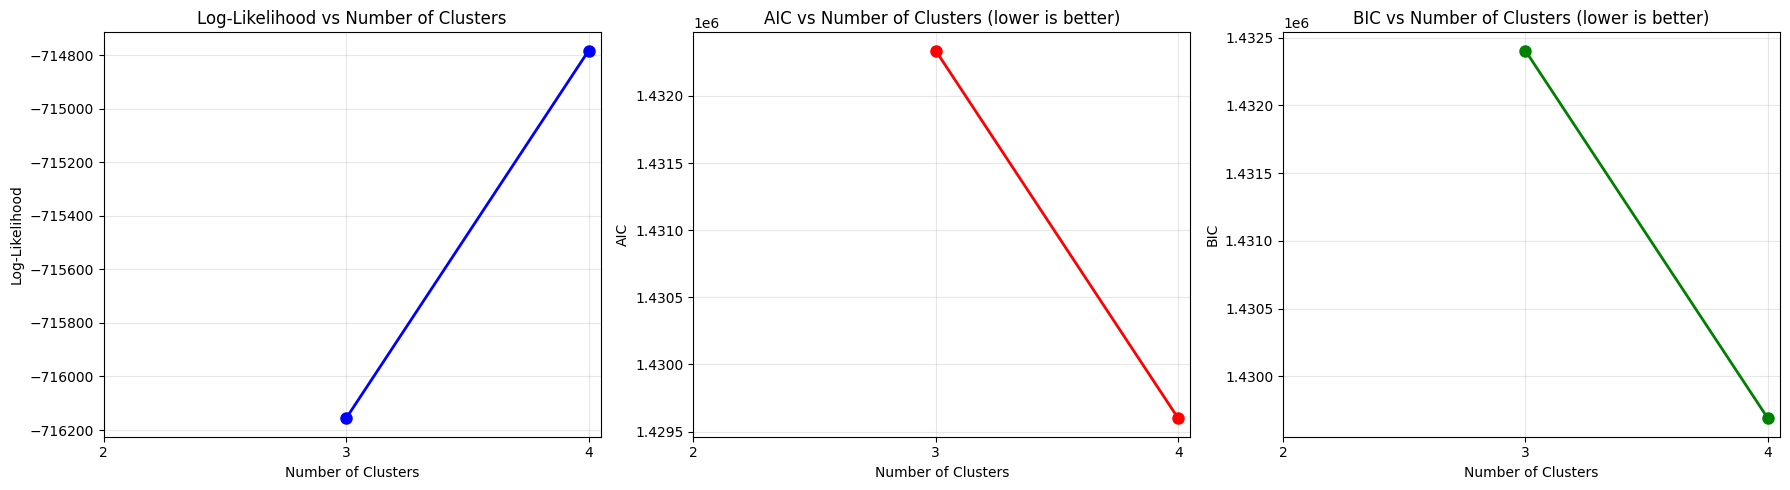

KeyError: 2

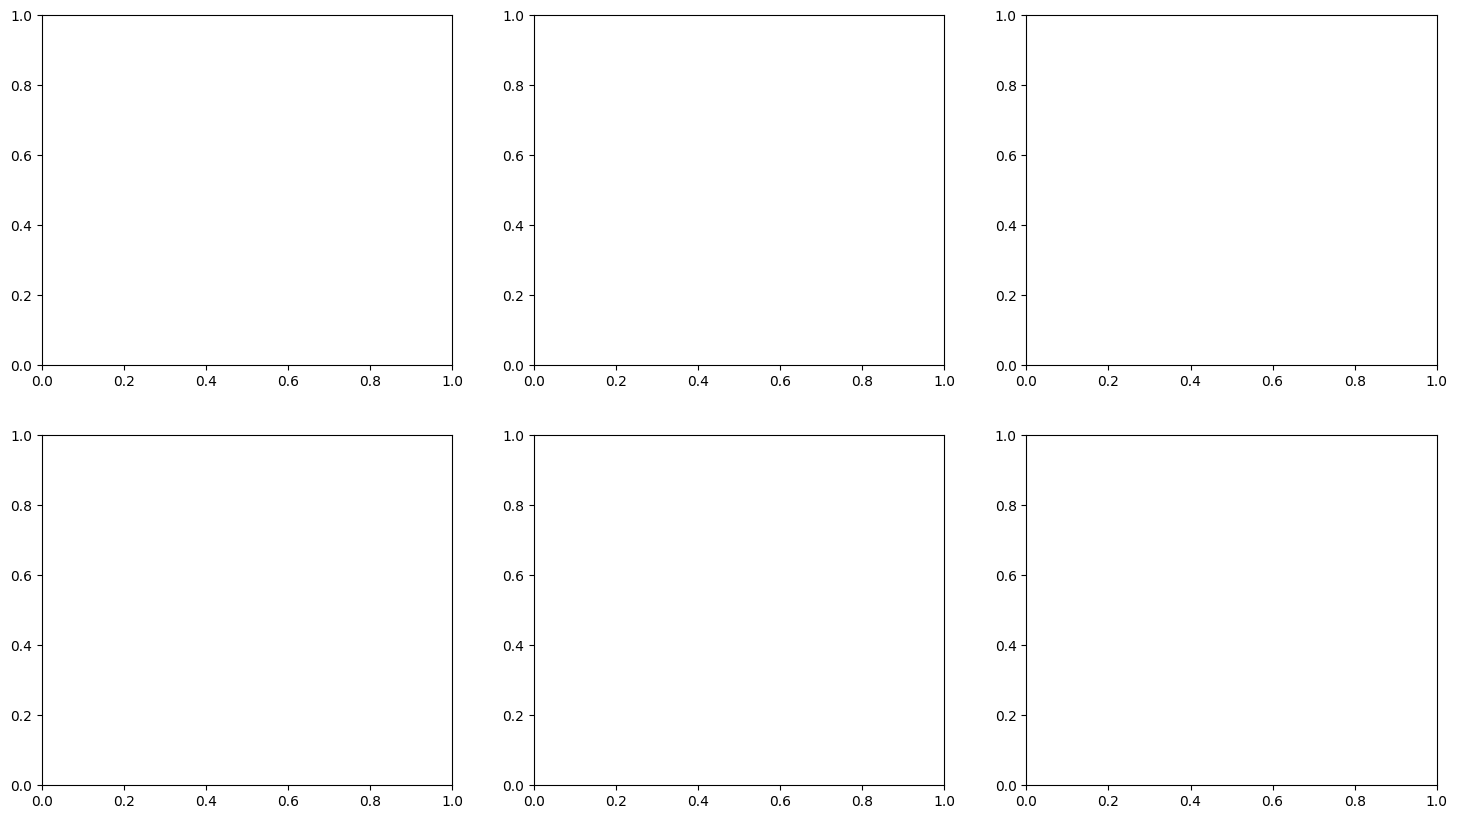

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point

sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

print("Individual Sector Parameters:")
print(df_params)

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# Load actual survival data - FIXED: Get consistent ages_data
survival_data = {}
ages_data = None  # Initialize to store consistent age bins

for i, sector in enumerate(sector_list):
    survival_fractions, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    survival_data[sector] = survival_fractions
    
    # Use the first sector's ages as reference for all sectors
    if i == 0:
        ages_data = ages

print(f"Using age bins from 0 to {max(ages_data):.1f} years with {len(ages_data)} bins")

def log_likelihood(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return -np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return logL

def reestimate_cluster_params_mle(cluster_sectors):
    """
    CORRECTED: Re-estimate parameters by maximizing likelihood on combined cluster data
    """
    # Combine data from all sectors in cluster
    combined_survivors = []
    combined_totals = []
    combined_ages = []
    
    for sector in cluster_sectors:
        totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
        
        # Ensure we only use data points where we have observations
        valid_mask = totals > 0
        survivors = survivors[valid_mask]
        totals = totals[valid_mask]
        
        # Use the same age bins for all sectors for consistency
        ages_sector = ages_data[:len(survivors)]  # Trim to match data length
        
        combined_survivors.extend(survivors)
        combined_totals.extend(totals)
        combined_ages.extend(ages_sector)
    
    combined_survivors = np.array(combined_survivors)
    combined_totals = np.array(combined_totals)
    combined_ages = np.array(combined_ages)
    
    # Remove any invalid data points
    valid_idx = (combined_totals > 0) & (combined_survivors >= 0) & (combined_survivors <= combined_totals)
    combined_survivors = combined_survivors[valid_idx]
    combined_totals = combined_totals[valid_idx]
    combined_ages = combined_ages[valid_idx]
    
    if len(combined_survivors) == 0:
        print(f"    Warning: No valid data for cluster {cluster_sectors}")
        return df_params.loc[cluster_sectors].mean().values
    
    # Define objective function
    def neg_log_likelihood(params):
        ll = log_likelihood(params, combined_ages, combined_survivors, combined_totals)
        return -ll if np.isfinite(ll) else 1e10
    
    # Use mean of individual sector parameters as initial guess
    initial_guess = df_params.loc[cluster_sectors].mean().values
    
    # Set reasonable bounds with more relaxed m bounds
    bounds = [(1e-6, 1.0),      # mu_ub
              (1e-10, 1.0),     # mu_lb  
              (0.1, 100.0),     # K
              (0.1, 200.0)]     # m - increased upper bound for more flexibility
    
    # Optimize with multiple attempts
    best_params = initial_guess
    best_ll = -1e10
    
    for attempt in range(3):  # Try multiple starting points
        try:
            if attempt == 0:
                start_params = initial_guess
            else:
                # Add some noise to initial guess for additional attempts
                # Use smaller noise for m parameter to avoid extreme values
                noise = np.random.normal(0, 0.1, size=4)
                noise[3] *= 0.5  # Reduce noise for m parameter
                start_params = np.abs(initial_guess + noise * initial_guess)
                # Ensure bounds are respected
                start_params[0] = np.clip(start_params[0], 1e-6, 1.0)
                start_params[1] = np.clip(start_params[1], 1e-10, min(1.0, start_params[0]))
                start_params[2] = np.clip(start_params[2], 0.1, 100.0)
                start_params[3] = np.clip(start_params[3], 0.1, 200.0)  # Updated bound
            
            result = minimize(neg_log_likelihood, start_params, 
                            method='L-BFGS-B', bounds=bounds)
            
            if result.success:
                ll = log_likelihood(result.x, combined_ages, combined_survivors, combined_totals)
                if ll > best_ll:
                    best_ll = ll
                    best_params = result.x
                    
        except Exception as e:
            print(f"    Optimization attempt {attempt+1} failed: {e}")
            continue
    
    return best_params

def compute_sector_likelihood(sector, model_params):
    """    
    CORRECTED: Compute likelihood of sector data given model parameters
    """
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', sector)
    
    # Use consistent age bins and filter out invalid data
    valid_mask = totals > 0
    survivors = survivors[valid_mask]
    totals = totals[valid_mask]
    ages_sector = ages_data[:len(survivors)]  # Use consistent age bins
    
    if len(survivors) == 0:
        return -np.inf
        
    return log_likelihood(model_params, ages_sector, survivors, totals)

# Generalized iterative clustering algorithm (rest of the code remains the same)
def iterative_likelihood_clustering(survival_data, df_params, n_clusters=2, max_iterations=20, tolerance=1, m_tolerance=0.5):
    """
    Iterative clustering using direct likelihood comparison - generalized for k clusters
    """
    n_sectors = len(survival_data)
    sector_names = list(survival_data.keys())
    
    # Step 1: Initialize with k-means clustering on parameters
    print(f"\nInitializing {n_clusters}-cluster analysis with k-means clustering...")
    print("K-means clustering works by:")
    print("  1. Randomly placing k cluster centers in the parameter space")
    print("  2. Assigning each sector to the nearest cluster center (Euclidean distance)")
    print("  3. Moving cluster centers to the mean of assigned sectors")
    print("  4. Repeating steps 2-3 until convergence")
    print("  This provides good initial cluster assignments based on parameter similarity")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    initial_clusters = kmeans.fit_predict(df_params.values)
    
    # Initialize cluster parameters as cluster centroids
    cluster_params = {}
    for cluster_id in range(n_clusters):
        mask = initial_clusters == cluster_id
        if np.sum(mask) > 0:
            cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
        else:
            cluster_params[cluster_id] = df_params.values[np.random.randint(0, n_sectors)]
    
    print("Initial cluster assignments:")
    for i, sector in enumerate(sector_names):
        print(f"  {sector}: Cluster {initial_clusters[i]}")
    
    print("Initial cluster parameters:")
    for cluster_id, params in cluster_params.items():
        n_in_cluster = np.sum(initial_clusters == cluster_id)
        print(f"  Cluster {cluster_id} ({n_in_cluster} sectors): {params}")
    
    # Iterative refinement
    current_clusters = initial_clusters.copy()
    iteration = 0
    converged = False
    
    history = {
        'iteration': [],
        'cluster_assignments': [],
        'cluster_params': [],
        'total_likelihood': []
    }
    
    while iteration < max_iterations and not converged:
        iteration += 1
        print(f"\n--- Iteration {iteration} ---")
        
        # Step 2: Assign sectors to clusters based on likelihood
        new_clusters = np.zeros(n_sectors, dtype=int)
        sector_likelihoods = {}
        
        for i, sector in enumerate(sector_names):
            cluster_lls = {}
            for cluster_id in range(n_clusters):
                cluster_lls[cluster_id] = compute_sector_likelihood(sector, cluster_params[cluster_id])
            
            best_cluster = max(cluster_lls.keys(), key=lambda k: cluster_lls[k])
            new_clusters[i] = best_cluster
            
            sector_likelihoods[sector] = {**cluster_lls, 'assigned': best_cluster}
        
        print("Likelihood-based assignments:")
        for sector, lls in sector_likelihoods.items():
            ll_str = ", ".join([f"LL_{k}={lls[k]:.2f}" for k in range(n_clusters)])
            print(f"  {sector}: {ll_str} → Cluster {lls['assigned']}")
        
        # Step 3: Re-estimate cluster parameters using MLE
        new_cluster_params = {}
        for cluster_id in range(n_clusters):
            mask = new_clusters == cluster_id
            cluster_sectors = [sector_names[i] for i in range(n_sectors) if mask[i]]
            
            if len(cluster_sectors) > 0:
                try:
                    new_cluster_params[cluster_id] = reestimate_cluster_params_mle(cluster_sectors)
                except Exception as e:
                    print(f"  Warning: MLE failed for cluster {cluster_id}: {e}, using mean")
                    new_cluster_params[cluster_id] = df_params.values[mask].mean(axis=0)
            else:
                new_cluster_params[cluster_id] = cluster_params[cluster_id]
                print(f"  Warning: Cluster {cluster_id} became empty, keeping old parameters")
        
        print("Updated cluster parameters:")
        for cluster_id, params in new_cluster_params.items():
            n_sectors_in_cluster = np.sum(new_clusters == cluster_id)
            print(f"  Cluster {cluster_id} ({n_sectors_in_cluster} sectors): {params}")
        
        # Check convergence with weighted parameter changes
        clusters_changed = not np.array_equal(current_clusters, new_clusters)
        
        # Calculate weighted parameter change - give less weight to m parameter
        param_change = 0
        param_weights = [1.0, 1.0, 1.0, 0.02]  # Less weight on m parameter (index 3)
        
        for cluster_id in range(n_clusters):
            old_params = cluster_params[cluster_id]
            new_params = new_cluster_params[cluster_id]
            
            # Weighted sum of squared differences
            weighted_diff = np.sum([(new_params[i] - old_params[i])**2 * param_weights[i] 
                                  for i in range(4)])
            param_change += weighted_diff
        
        # Also check relative changes for m parameter specifically
        max_m_relative_change = 0
        for cluster_id in range(n_clusters):
            old_m = cluster_params[cluster_id][3]
            new_m = new_cluster_params[cluster_id][3]
            if old_m > 0:
                m_relative_change = abs(new_m - old_m) / old_m
                max_m_relative_change = max(max_m_relative_change, m_relative_change)
        
        print(f"  Clusters changed: {clusters_changed}")
        print(f"  Weighted parameter change: {param_change:.6f}")
        print(f"  Max relative m change: {max_m_relative_change:.3f}")
        
        # More tolerant convergence criteria
        m_tolerance = 0.5  # Allow 50% relative change in m parameter
        if (not clusters_changed and 
            param_change < tolerance and 
            max_m_relative_change < m_tolerance):
            converged = True
            print("  → Converged!")
        
        # Compute total likelihood
        total_ll = 0
        for i, sector in enumerate(sector_names):
            assigned_cluster = new_clusters[i]
            total_ll += compute_sector_likelihood(sector, new_cluster_params[assigned_cluster])
        
        # Store history
        history['iteration'].append(iteration)
        history['cluster_assignments'].append(new_clusters.copy())
        history['cluster_params'].append(new_cluster_params.copy())
        history['total_likelihood'].append(total_ll)
        
        # Update for next iteration
        current_clusters = new_clusters.copy()
        cluster_params = new_cluster_params.copy()
    
    if not converged:
        print(f"\nWarning: Did not converge after {max_iterations} iterations")
    
    return current_clusters, cluster_params, history

# Function to compute AIC and BIC for model comparison
def compute_model_selection_criteria(final_clusters, final_params, n_clusters):
    """
    Compute AIC and BIC for the clustering solution
    """
    total_ll = 0
    total_obs = 0
    
    for i, sector in enumerate(sector_list):
        assigned_cluster = final_clusters[i]
        sector_ll = compute_sector_likelihood(sector, final_params[assigned_cluster])
        total_ll += sector_ll
        
        # Count actual observations for this sector
        totals, _ = obtain_total_alive_count(df_analysis, 'Sector', sector)
        total_obs += np.sum(totals > 0)
    
    # Number of parameters: n_clusters * 4 parameters per cluster
    n_params = n_clusters * 4
    
    # AIC and BIC
    AIC = -2 * total_ll + 2 * n_params
    BIC = -2 * total_ll + np.log(total_obs) * n_params
    
    return total_ll, AIC, BIC, n_params

# Run clustering for k = 2, 3, 4
results = {}
model_comparison = {}

for k in [3, 4]:
    print(f"\n{'='*60}")
    print(f"RUNNING {k}-CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    final_clusters, final_params, history = iterative_likelihood_clustering(
        survival_data, df_params, n_clusters=k
    )
    
    # Store results
    results[k] = {
        'clusters': final_clusters,
        'params': final_params,
        'history': history
    }
    
    # Compute model selection criteria
    total_ll, AIC, BIC, n_params = compute_model_selection_criteria(final_clusters, final_params, k)
    model_comparison[k] = {
        'log_likelihood': total_ll,
        'AIC': AIC,
        'BIC': BIC,
        'n_params': n_params
    }
    
    print(f"\n{k}-CLUSTER FINAL RESULTS:")
    print(f"Total Log-Likelihood: {total_ll:.2f}")
    print(f"AIC: {AIC:.2f}")
    print(f"BIC: {BIC:.2f}")
    
    print(f"\nFinal cluster assignments:")
    for i, sector in enumerate(sector_list):
        print(f"  {sector}: Cluster {final_clusters[i]}")
    
    print(f"\nFinal cluster parameters:")
    for cluster_id, params in final_params.items():
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        print(f"\nCluster {cluster_id} ({n_sectors} sectors): {sectors_in_cluster}")
        print(f"  mu_ub: {params[0]:.6f}")
        print(f"  mu_lb: {params[1]:.6f}")
        print(f"  K: {params[2]:.6f}")
        print(f"  m: {params[3]:.6f}")

# Model comparison summary
print(f"\n{'='*60}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*60}")

comparison_df = pd.DataFrame(model_comparison).T
comparison_df.index.name = 'n_clusters'
print(comparison_df)

# Find best model by AIC and BIC
best_aic = comparison_df['AIC'].idxmin()
best_bic = comparison_df['BIC'].idxmin()
best_ll = comparison_df['log_likelihood'].idxmax()

print(f"\nBest model by AIC: {best_aic} clusters")
print(f"Best model by BIC: {best_bic} clusters")
print(f"Best model by Log-Likelihood: {best_ll} clusters")

# Visualization code remains the same...
# [Rest of plotting code would go here]

# Visualization code remains the same...
# [Rest of plotting code would go here]# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Log-likelihood
axes[0].plot(comparison_df.index, comparison_df['log_likelihood'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Log-Likelihood')
axes[0].set_title('Log-Likelihood vs Number of Clusters')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([2, 3, 4])

# AIC
axes[1].plot(comparison_df.index, comparison_df['AIC'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC vs Number of Clusters (lower is better)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks([2, 3, 4])

# BIC
axes[2].plot(comparison_df.index, comparison_df['BIC'], 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('BIC')
axes[2].set_title('BIC vs Number of Clusters (lower is better)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks([2, 3, 4])

plt.tight_layout()
plt.show()

# Plot convergence for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

colors = ['blue', 'red', 'green']
cluster_labels = [2, 3, 4]

for idx, k in enumerate([3, 4]):
    history = results[k]['history']
    
    # Total likelihood over iterations
    axes[0, idx].plot(history['iteration'], history['total_likelihood'], 
                     'o-', color=colors[idx], linewidth=2, markersize=6)
    axes[0, idx].set_xlabel('Iteration')
    axes[0, idx].set_ylabel('Total Log-Likelihood')
    axes[0, idx].set_title(f'{k} Clusters: Likelihood Convergence')
    axes[0, idx].grid(True, alpha=0.3)
    
    # Cluster changes over iterations
    cluster_changes = []
    for i in range(1, len(history['cluster_assignments'])):
        prev_clusters = history['cluster_assignments'][i-1]
        curr_clusters = history['cluster_assignments'][i]
        n_changes = np.sum(prev_clusters != curr_clusters)
        cluster_changes.append(n_changes)
    
    if cluster_changes:
        axes[1, idx].plot(range(2, len(history['iteration'])+1), cluster_changes, 
                         'o-', color=colors[idx], linewidth=2, markersize=6)
        axes[1, idx].set_xlabel('Iteration')
        axes[1, idx].set_ylabel('Number of Sectors Changed Clusters')
        axes[1, idx].set_title(f'{k} Clusters: Assignment Changes')
        axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot representative survival curves for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ages_plot = np.linspace(0.1, 30, 300)
colors_list = [['red', 'blue'], 
               ['red', 'blue', 'green'], 
               ['red', 'blue', 'green', 'orange']]

for idx, k in enumerate([2, 3, 4]):
    ax = axes[idx]
    final_clusters = results[k]['clusters']
    final_params = results[k]['params']
    colors = colors_list[idx]
    
    for cluster_id, params in final_params.items():
        survival_curve = model_survival_curve_hill(ages_plot, *params)
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        
        ax.plot(ages_plot, survival_curve, color=colors[cluster_id], linewidth=3,
                label=f'Cluster {cluster_id} ({n_sectors}): {sectors_in_cluster}')
    
    ax.set_xlabel('Firm Age (years)')
    ax.set_ylabel('Survival Fraction f(a)')
    ax.set_title(f'{k} Clusters: Representative Survival Curves')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed comparison table
print(f"\n{'='*60}")
print("DETAILED CLUSTER ASSIGNMENTS COMPARISON")
print(f"{'='*60}")

assignment_comparison = pd.DataFrame({
    '2_clusters': results[2]['clusters'],
    '3_clusters': results[3]['clusters'],
    '4_clusters': results[4]['clusters']
}, index=sector_list)

print(assignment_comparison)

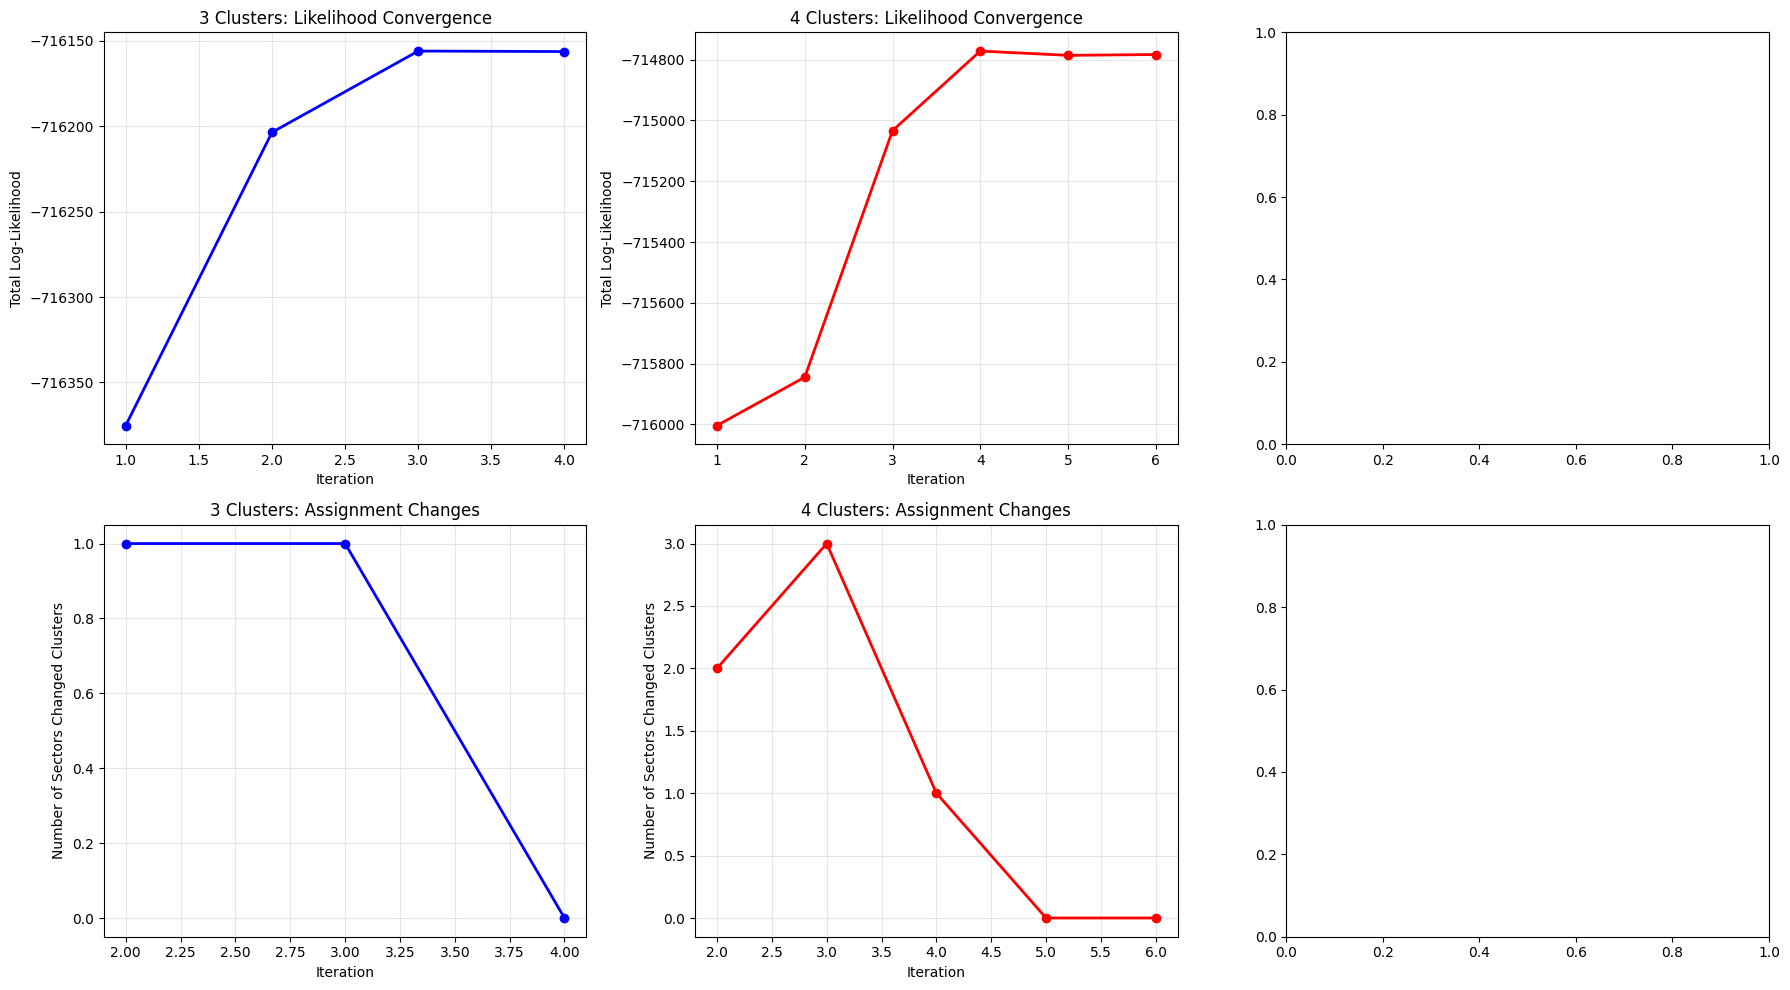

IndexError: list index out of range

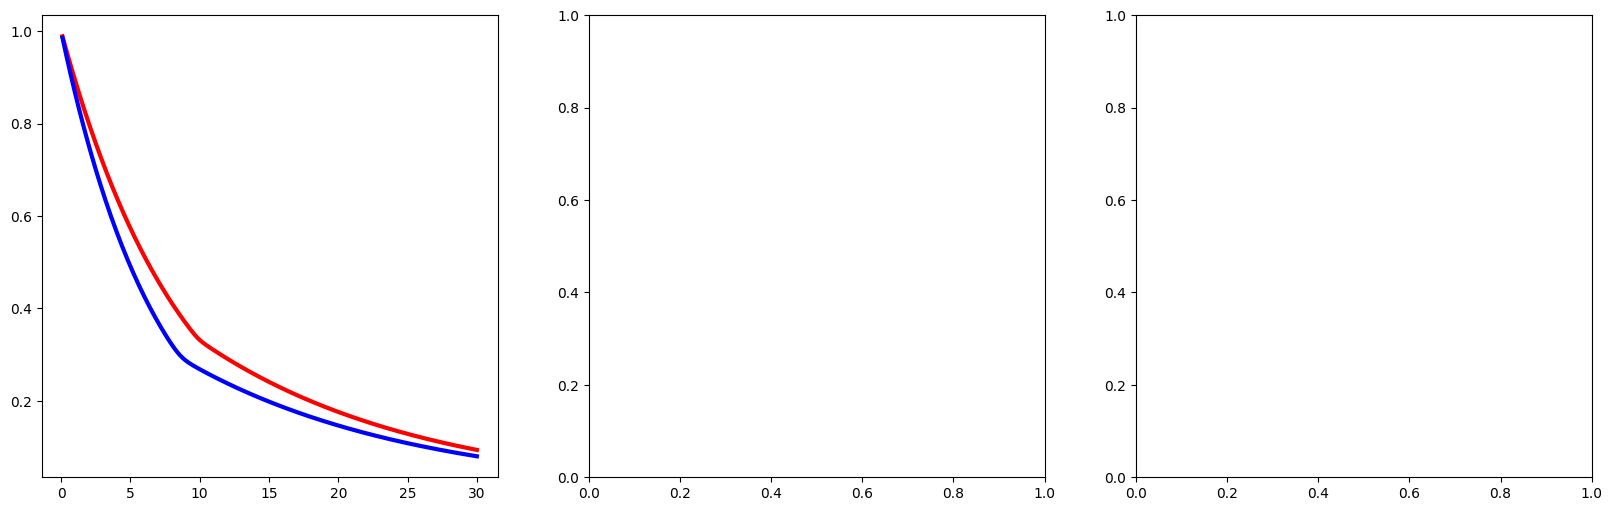

In [12]:
# Plot convergence for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

colors = ['blue', 'red', 'green']
cluster_labels = [2, 3, 4]

for idx, k in enumerate([3, 4]):
    history = results[k]['history']
    
    # Total likelihood over iterations
    axes[0, idx].plot(history['iteration'], history['total_likelihood'], 
                     'o-', color=colors[idx], linewidth=2, markersize=6)
    axes[0, idx].set_xlabel('Iteration')
    axes[0, idx].set_ylabel('Total Log-Likelihood')
    axes[0, idx].set_title(f'{k} Clusters: Likelihood Convergence')
    axes[0, idx].grid(True, alpha=0.3)
    
    # Cluster changes over iterations
    cluster_changes = []
    for i in range(1, len(history['cluster_assignments'])):
        prev_clusters = history['cluster_assignments'][i-1]
        curr_clusters = history['cluster_assignments'][i]
        n_changes = np.sum(prev_clusters != curr_clusters)
        cluster_changes.append(n_changes)
    
    if cluster_changes:
        axes[1, idx].plot(range(2, len(history['iteration'])+1), cluster_changes, 
                         'o-', color=colors[idx], linewidth=2, markersize=6)
        axes[1, idx].set_xlabel('Iteration')
        axes[1, idx].set_ylabel('Number of Sectors Changed Clusters')
        axes[1, idx].set_title(f'{k} Clusters: Assignment Changes')
        axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot representative survival curves for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ages_plot = np.linspace(0.1, 30, 300)
colors_list = [['red', 'blue'], 
               ['red', 'blue', 'green'], 
               ['red', 'blue', 'green', 'orange']]

for idx, k in enumerate([3, 4]):
    ax = axes[idx]
    final_clusters = results[k]['clusters']
    final_params = results[k]['params']
    colors = colors_list[idx]
    
    for cluster_id, params in final_params.items():
        survival_curve = model_survival_curve_hill(ages_plot, *params)
        n_sectors = np.sum(final_clusters == cluster_id)
        sectors_in_cluster = [sector_list[i] for i in range(len(sector_list)) if final_clusters[i] == cluster_id]
        
        ax.plot(ages_plot, survival_curve, color=colors[cluster_id], linewidth=3,
                label=f'Cluster {cluster_id} ({n_sectors}): {sectors_in_cluster}')
    
    ax.set_xlabel('Firm Age (years)')
    ax.set_ylabel('Survival Fraction f(a)')
    ax.set_title(f'{k} Clusters: Representative Survival Curves')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed comparison table
print(f"\n{'='*60}")
print("DETAILED CLUSTER ASSIGNMENTS COMPARISON")
print(f"{'='*60}")

assignment_comparison = pd.DataFrame({
    '2_clusters': results[2]['clusters'],
    '3_clusters': results[3]['clusters'],
    '4_clusters': results[4]['clusters']
}, index=sector_list)

print(assignment_comparison)